In [4]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
mpl.rcParams['figure.figsize'] = (9,6)

![model](https://i.stack.imgur.com/GSA92.png![image.png](attachment:image.png)

The idea here is that we have a set of measurements that seem to be normally distributed but we want to find a way to estimate the parameters of the true distribution. Monte carlo methods are a broad category of sampling algorithms that evaluate the likelihood of data coming from distributions of different sampled parameters. AKA if the data is believed to be normal, a Monte Carlo algorithm samples a number of possible location and scale parameters for the distribution, focusing on values of those parameters where the likelihood of the observed data is highest.

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(65,0.1,'outliers?')

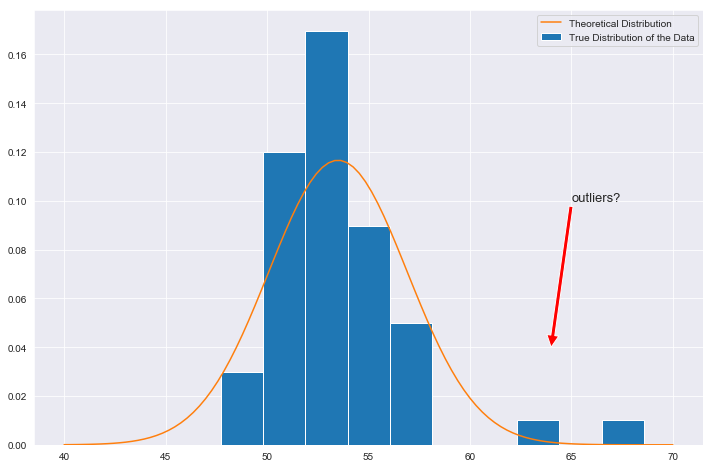

In [5]:
plt.figure(figsize=(12,8))

# measured mu = 53.5, measured sigma = 3.42
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

# There are some potential outliers however?
plt.hist(data, label='True Distribution of the Data', weights=[1/len(data) for _ in data], normed=True)
# theoretical normal distribution with mu and sigma (as taken from the data)
normal_dist = stats.norm(data.mean(), data.std())
plt.plot(np.linspace(40,70,100), normal_dist.pdf(np.linspace(40,70,100)), label='Theoretical Distribution')
plt.legend()
plt.annotate(s='outliers?', xy=(64,0.04), xytext=(65,0.1), arrowprops={'facecolor':'red', 'shrink':1}, fontsize=13)

# The theoretical distribution is wider than may be expected due to those high values.

One of the perks of bayesian modeling is the ability to specify prior distributions for the modelers belief in the distribution. In the above example we could believe that those high values are indeed outliers and that our true distribution has a mean lower than the one measured. We can indicate this belief in the setup of our sampling method and it will influence the resulting distribution.

In [4]:
# mean of data with and without outliers
data.mean(), data[data<60].mean()

(53.49645833333333, 52.95260869565218)

Let's say we believe that the data is realy centered somewhere around 50, and that our current measurements just happen to be higher than usual by chance.

We can indicate this belief with a prior distribution with a mean of 50. Our certainty in our belief can be indicated by the standard deviation of the prior distribution. A higher std (wider distribution of possibilities) allows for the possiblity of the true mean being further away from our prior mean, whiel a small std (tall-narrow distribution) indicates high confidence that the true mean is very close to the prior mean.


We are going to set our prior belief to a normal distribution of 50 with std of 3. This means that we believe the true mean is around 50 but think it's probable that it could fall within about 6 points (2 std) in either direction with decreasing probability. 

Text(0,0.5,'Probabiity of Mu Being That Value')

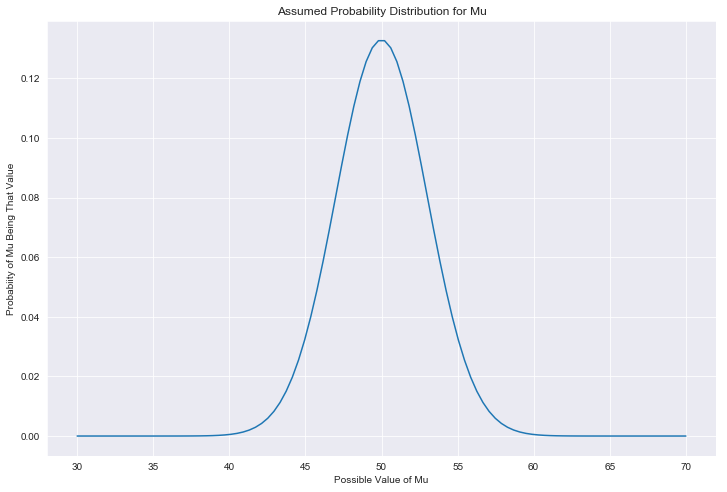

In [6]:
# Create a normal distribution for guessing the value of mu
# we think mu is around 50 so we set the mean of this normal distribution to 50
mu_prior_mean = 50
# the standard deviation defines how wide a variety of values we expect to see
mu_prior_std = 3

# here is our guess (prior) distribution
mu_prior = stats.norm(mu_prior_mean,mu_prior_std)

# plot it
plt.figure(figsize=(12,8))
x = np.linspace(30,70, 100)
plt.plot(x,mu_prior.pdf(x))
plt.title('Assumed Probability Distribution for Mu')
plt.xlabel('Possible Value of Mu')
plt.ylabel('Probabiity of Mu Being That Value')

NOTE that this is not the distribution that represents our _data_, but the distribution that 
represents the ___mean___ _of the distribution of our data_.

We are going to do the same thing for the _true_ value of sigma. For this example we are going to also assume the true value of sigma can be described by a normal distribution with a standard deviation (level of certainty/ variety) of 5. 

This is to say that we allow for more possiblity that the distribution of the data can be wider than indicated by the measurments themself. 

However we know that sigma can't be less than 0 (A standard deviation of less than 0 doesn't make sense), so we are going to only use the right half of the distribution.

Text(0,0.5,'Probabiity of Sigma Being That Value')

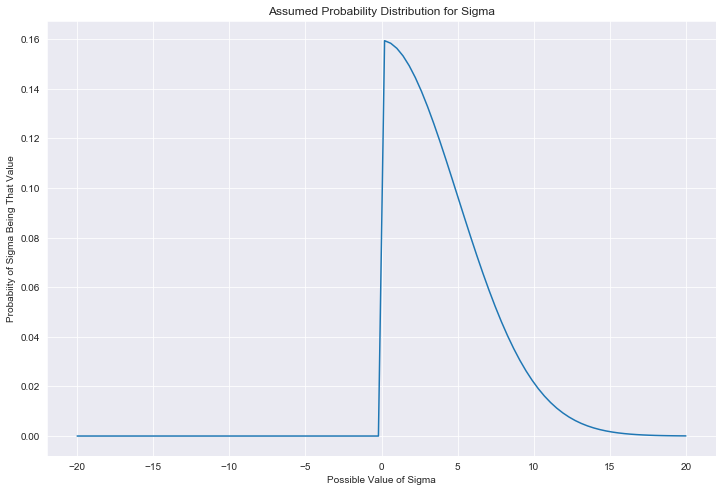

In [7]:
# center the distribution at 0 (and then only use the right half)
sigma_prior_mean = 0

# the standard deviation defines how wide a variety of values we expect to see
sigma_prior_std = 5

# here is our guess (prior) distribution
sigma_prior = stats.halfnorm(sigma_prior_mean, sigma_prior_std)

# plot it
plt.figure(figsize=(12,8))
x = np.linspace(-20,20, 100)
plt.plot(x,sigma_prior.pdf(x))
plt.title('Assumed Probability Distribution for Sigma')
plt.xlabel('Possible Value of Sigma')
plt.ylabel('Probabiity of Sigma Being That Value')

Remember that mu and sigma are going to be used as the mean and standard deviation of a normal distribution that we think will optimally describe the real_valued process that generates the data we are looking at.

## Metropolis Algorithm

The metropolis algorithm works by collecting samples of random values and saving them to our collection under the condition that the new sample increases the likelihood of the data more than the previous sample. Howeer there is one caveat. The metropolis algorithm will still save samples that don't increase the likelihood of the data randomly here and there. This allows it to explore more of the space of the sampling distribution even if it doesn't directly maximize the likelihood of the measured data imediately. 

The result of accepting less likely samples is a _distribution_ around the true parameters of our process, rather than just a point estimate.

The criteria for accepting inferior sampled parameters is to take the ratio of the posterior of the new sample to the posterior of the old sample and compare it to a random value sampled form a uniform distribution.

Aka you accept the new sample if:

$ \frac{P(new_sample)}{p(old_sample) > rUniform(0,1) $


The Proposal Distribution used to select new samples can affect the outcome of the sampling and
acan be tuned via it's standard deviation (sj).

Ideally sj is tuned to give acceptance probability around 0.3-0.4.

#### Example:

For simplicity sake, first assume sigma is fixed

In [24]:

# measured mu = 53.5, measured sigma = 3.42
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

# play with these to adjust the prior
# M = prior assumption for mu
# S = prior assumption of std
M, S = 50, 3

# prior dist for mu is a normal distrubtion with mean= M and std = S
mu_prior_dist = stats.norm(loc=M, scale=S)

# likelihood distribution is a normal distribution with mean=mu, std=sigma
target_dist = stats.norm

# proposal distribution
prop_dist = stats.norm

# First guess at mu (just using prior here)
mu_old = M
sigma = S # assuming sigma is fixed in this example

# evaluate prior for initial mu 
mu_prior = mu_prior_dist.pdf(mu_old)
print('MU PRIOR:', mu_prior)

# Using current mu and sigma calculate likelihood as a PRODUCT
# NOTE normally you would calculate log-likelihood so you can calculate the likelihood as the 
#+ sum of logs.
likelihood = target_dist.pdf(data, loc=mu_old, scale=sigma).prod()
print('FIRST LIKELIHOOD:', likelihood)

# calculate un-normalized posterior
# bayes theorem = posterior = likelihood*prior/evidence
# where evidence is a normalizing factor 
post_old = likelihood*mu_prior
print(post_old)

# num samples
steps = 2500

# save all the samples we are gonna take
mu_samples = [mu_old]

for i in range(steps):
    
    # generate a new proposed mu from a *proposal distribution* (more on this later)
    # generally this is "select a new mu that's _relatively_ close to the old one"
    # .rvs() generates a random sample
    mu_i = prop_dist.rvs(mu_old, 0.1) # 0.1 is an arbitrary std (can be tuned)
    
    # calculate prior prob of new mu_i
    mu_i_prior = mu_prior_dist.pdf(mu_i)
  
    # calculate likelihood with new distribution (using new mu_i)
    new_likelihood = target_dist.pdf(data, loc=mu_i, scale=sigma).prod()
    
    # calculate new unormalized posterior
    new_post = new_likelihood * mu_i_prior

    # if new posterior is greater than previous posterior we are going to accept it.
    # Otherwise we accept based on whether or not the ratio of posteriors (new/old)
    #+ is greater than a value drawn from a uniform distribution between 0 and 1
    a = min([1,new_post/post_old])
    acceptance_bar = np.random.random() # random number between 0-1

    # either accept this sample and save it
    #+ or move on to next iteration
    if a > acceptance_bar:
        mu_samples.append(mu_i)
        mu_old = mu_i
        post_old = new_post

MU PRIOR: 0.1329807601338109
FIRST LIKELIHOOD: 1.7287723012561542e-70
2.2989345471932092e-71


You can see our prior had little effect over the sampling process as the data quickly overwhelmed the prior. You can play around and strengthen the prior by lowering the std of the prior guess.

53.26576290087925

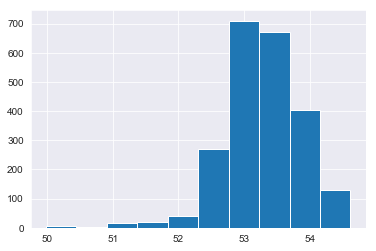

In [25]:
plt.hist(mu_samples)
np.mean(mu_samples)

The ideal sampling process looks like a random walk through time

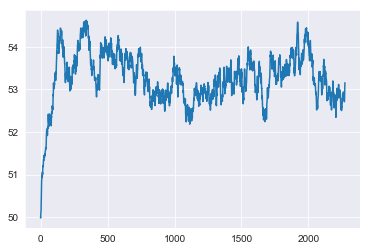

In [26]:
plt.plot(mu_samples) # this is prob not good...aa

/Users/rick.shapiro/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(40,0.178272,'STD: 3.0')

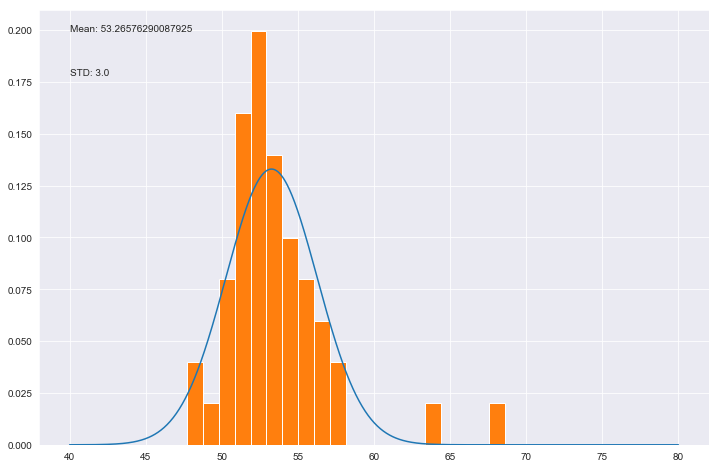

In [27]:
# posterior is the target distribution with the average of mu
target = target_dist(np.mean(mu_samples), sigma)

plt.figure(figsize=(12,8))

x = np.linspace(40,80,1000)
plt.plot(x,target.pdf(x))
plt.hist(data, 20, normed=True,  weights=[1/len(data) for _ in data])
plt.text(40, plt.ylim()[1]*0.95, "Mean: " + str(target.mean()))
plt.text(40,  plt.ylim()[1]*0.85, "STD: "+ str(target.std()))


Text(0.5,1,'Histogram of Mu Samples')

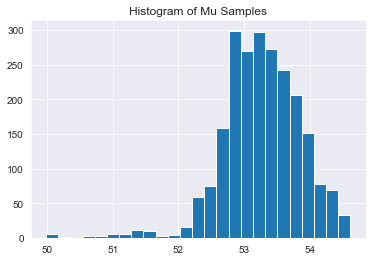

In [28]:
plt.hist(mu_samples, 25);
plt.title('Histogram of Mu Samples')

### Metropolis Algorithm For Solving BOTH mu & sigma

Mu prior will again be a normal distribution
Sigma Prior is gonna be a half-cauchy. (As far as I can tell this looks just like a half-normal)

In [29]:
def sample(param_old, prior_dist, target_dist, nsamples=2500):
    param_prior = prior_dist.pdf(param_old)
    likelihood = target_dist.pdf(data, loc=mu_old, )

In [30]:

# measured mu = 53.5, measured sigma = 3.42
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])

# play with these to adjust the prior
M, S = 50, 3
G = 3 # std of sigma_prior_dist

# prior dist for mu is a normal distrubtion with mean= M and std = S
mu_prior_dist = stats.norm(loc=M, scale=S)
sigma_prior_dist = stats.halfnorm(scale=G)

# likelihood distribution is a normal distribution with mean=mu, std=sigma
target_dist = stats.norm

# proposal distribution
mu_prop_dist = stats.norm
sigma_prop_dist = stats.norm

# First guess at mu & sigma
mu_old = M
sigma_old = S

# not sure if we just do each separately or what...

param_dic = {
    'mu': {'prior_dist': mu_prior_dist, 'prop_dist': mu_prop_dist, 'old': mu_old, 'current':mu_old},
    'sigma': {'prior_dist': sigma_prior_dist, 'prop_dist': sigma_prop_dist, 'old': sigma_old, 'current':sigma_old},
}


for param in ['mu','sigma']:
    print(param)
    print('----------------')
    # evaluate prior for initial mu, sigma
    param_prior = param_dic[param]['prior_dist'].pdf(param_dic[param]['old'])
    print(param_prior)

    # Using current mu and sigma calculate likelihood as a PRODUCT
    likelihood = target_dist.pdf(data, loc=param_dic['mu']['old'], scale=param_dic['sigma']['old']).prod()
    print(likelihood)

    # calculate un-normalized posterior
    # bayes theorem = posterior = likelihood*prior/evidence
    # where evidence is a normalizing factor 
    post_old = likelihood*param_prior
    print(post_old)

    steps = 2500

    # save all the samples we are gonna take
    param_samples = [param_dic[param]['old']]

    for i in range(steps):

        # generate a new proposed param from a *proposal distribution* (more on this later)
        # generally this is "select a new param that's _relatively_ close to the old one"
        # .rvs() generates a random sample
        param_i = param_dic[param]['prop_dist'].rvs(loc=param_samples[-1], scale=0.1) # 0.1 is an arbitrary std
        param_dic[param]['current'] = param_i
        
        # calculate prior prob of new param
        param_i_prior = param_dic[param]['prior_dist'].pdf(param_i)

        # calculate likelihood with new distribution (using new param_i)
        new_likelihood = target_dist.pdf(data, loc=param_dic['mu']['current'], scale=param_dic['sigma']['current']).prod()
        
        # calculate new unormalized posterior
        new_post = new_likelihood * param_i_prior

        # if new posterior is greater than previous posterior we are going to accept it.
        # Otherwise we accept based on whether or not the ratio of posteriors (new/old)
        #+ is greater than a value drawn from a uniform distribution between 0 and 1
        a = min([1,new_post/post_old])
        acceptance_bar = np.random.random() # random number between 0-1

        # either accept this sample and save it
        #+ or move on to next iteration
        if a > acceptance_bar:
            param_samples.append(param_i)
            param_dic[param]['old'] = param_i
            post_old = new_post
        
    param_dic[param]['sample'] = param_samples
#     param_dic['mu']['old'] = mu_old
#     param_dic['sigma']['old'] = sigma_old

mu
----------------
0.1329807601338109
1.7287723012561542e-70
2.2989345471932092e-71
sigma
----------------
0.16131381634609557
2.230698624158457e-56
3.598425081809854e-57


In [31]:
mu_samples = param_dic['mu']['sample']
sigma_samples = param_dic['sigma']['sample']

53.33243344739488

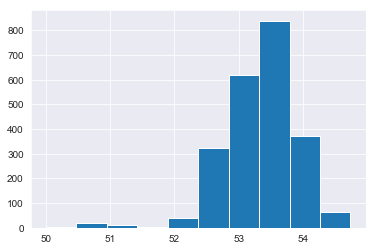

In [32]:
plt.hist(mu_samples)
np.mean(mu_samples)

3.580343792823441

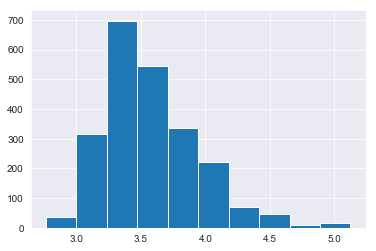

In [33]:
plt.hist(sigma_samples)
np.mean(sigma_samples)

Two things to try:
    - Adjust the priors
    - Use a Students T distribution for the likelihood

In [34]:
import pymc3 as pm

In [38]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34, 55.65, 51.49, 51.86, 63.43, 
                 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 
                 51.36, 55.47, 50.73, 51.94, 54.95, 50.39, 52.91, 51.5, 52.68, 47.72, 
                 49.73, 51.82, 54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.3, 53.84, 53.16])
mod = pm.Model()


with mod:
    mu = pm.Normal('mu', 50,3) # mu prior
    sigma = pm.HalfNormal('sigma', 3) # prior for std
    y = pm.Normal('y', mu, sigma, observed = data)
    
    step = pm.Metropolis() # metropolis algo
    start= {'mu': 50, 'sigma': 3} # initial guess
    
    trace = pm.sample(3000, step=step, start=start) #sample
    chain = trace[100:]
    

100%|██████████| 3500/3500 [00:00<00:00, 4214.54it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117c0e5f8>,
      dtype=object)

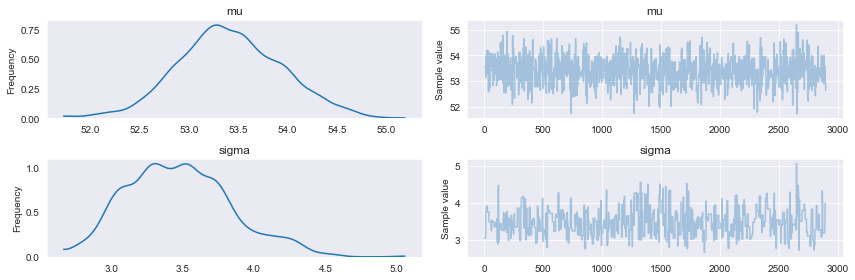

In [39]:
pm.traceplot(chain)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1194fc0b8>,
      dtype=object)

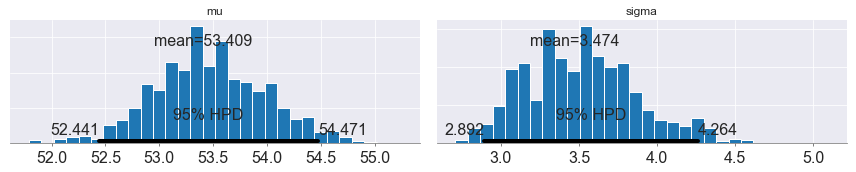

In [40]:
pm.plot_posterior(chain)

In [41]:
chain['mu'].mean(), chain['sigma'].mean()

(53.40864541124143, 3.473581199564552)